# Plots for the 2MDM analysis

In [2]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from auxPlots import columnsDict, colorDict, defaultPars
from scipy.interpolate import griddata
import itertools

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings
plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [3]:
#Merge with SModelS DataFrame
pclFile = '../data/smodels_results.pcl'
dataDF = pd.read_pickle(pclFile)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['maxcond', 'theory prediction (fb)', 'upper limit (fb)', 'expected upper limit (fb)', 'TxNames', 'Mass (GeV)', 'AnalysisID', 'DataSetID', 'AnalysisSqrts (TeV)', 'lumi (fb-1)', 'dataType', 'r', 'r_expected', 'Width (GeV)', 'nll', 'nll_min', 'nll_SM', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'BRs.sd.t-,t+', 'totalxsec13TeV

#### Filter couplings

In [4]:
gchi = np.sqrt(2)
gq = 0.25
sina = 0.25
dataDF = dataDF[(np.abs(dataDF['gchi']-gchi) < 0.001) & (dataDF['gq'] == gq) & (dataDF['sina'] == sina)]

#### Set r = 0 for points with no results 

In [5]:
#Set points without results with r == 0
dataDF.fillna(value={'r' : 0}, inplace=True)
dataDF.sort_values(by='r',ascending=False,inplace=True)

### Define the MET searches to be considered

In [16]:
metAna = ['CMS-EXO-20-004','ATLAS-EXOT-2018-06',
          'ATLAS-SUSY-2018-22-multibin','ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004']

#### Create legend for plots for excluded points

In [17]:
legendsDict = {ana: ana.replace('-multibin','') for ana in metAna}
legendsDict['CombinedAna'] = 'ATLAS-SUSY-2018-22'+'\n'+'+ CMS-EXO-20-004'
legendsDict['ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004'] = legendsDict['CombinedAna']


# Plot Results

ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004
ATLAS-SUSY-2018-22-multibin
ATLAS-EXOT-2018-06
CMS-EXO-20-004


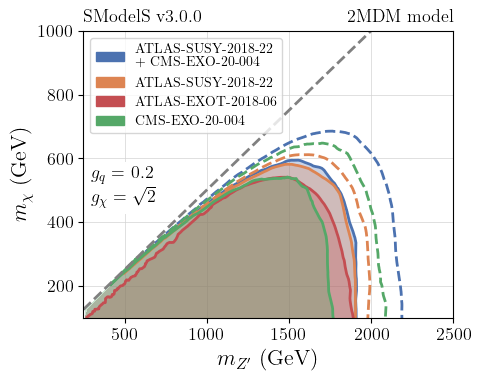

In [18]:
legends = []

anaGroups = dataDF.groupby('AnalysisID')
# Sort analyses by length of name and then length of points
for ana,anadf in sorted(anaGroups, key = lambda x: (len(x[0]),len(x[1])),reverse=True):
    if ana not in metAna:
        continue
    # Sort by r, so highest value comes first
    data = anadf.sort_values(by='r',axis=0,ascending=False)
    # Keep only the strongest result for a given analysis (first entry)
    data = data.groupby(level='filename').first()
    x = data['mZp']
    y = data['mChi']
    # sc = plt.scatter(x,y,s=60, color=colorDict[ana], label=legendsDict[ana], alpha=0.7)
    pts = np.array([y for y in itertools.product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(x,y)),data['r'],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[ana])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.3, colors=colorDict[ana])
    legends.append(mpatches.Patch(color=colorDict[ana], label=legendsDict[ana]))

    rPts = griddata(list(zip(x,y)),data['r_expected'],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    if len(pts) == 0:
        continue
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[ana],linestyles='dashed')


    

plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
textstr = '\n'.join((
    r'$g_q =$ %1.1f' %gq, 
    r'$g_{\chi} = \sqrt{2}$'))

plt.text(0.02,0.4,textstr,
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)

plt.xlim(250,2500)
plt.ylim(100, 1000)

plt.legend(handles=legends, loc='upper left')
plt.tight_layout()
plt.savefig('./figures/monojet-combined-anas2.png')
plt.show()